In [3]:
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from utils import reduce_mem_usage, WellLogsProcessing
import sys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'


plt.style.use("ggplot")
%load_ext autoreload
%autoreload 2

In [4]:
data_folder = "data/"

## Read preprocessed data 
Read processed data we've generated with data_processing.ipynb

In [5]:
dest_file = data_folder + "filled_train.csv"
filled_df = pd.read_csv(dest_file, sep=",")
penalty = np.load(data_folder + "penalty_matrix.npy")

In [6]:
filled_df.head()

,RMED,RDEP,RHOB,GR,NPHI,DTC,RXO,RSHA,X_LOC,Y_LOC,Z_LOC,DEPTH_MD,GROUP,FORMATION,WELL,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,0.069243,0.200645,-0.981618,0.286794,0.928137,0.962267,-1.293497,-1.903633,-0.630007,-1.470158,1.118759,-1.099449,NORDLAND GP.,Utsira Fm.,15/9-13,65000,1.0
1,0.072731,0.198845,-0.967846,0.263845,0.913967,0.952204,-1.283948,-1.875581,-0.630007,-1.470158,1.118652,-1.099345,NORDLAND GP.,Utsira Fm.,15/9-13,65000,1.0
2,0.077124,0.201860,-0.951319,0.155192,0.888734,0.944007,-1.248175,-1.832704,-0.630007,-1.470158,1.118545,-1.099240,NORDLAND GP.,Utsira Fm.,15/9-13,65000,1.0
3,0.074576,0.202324,-0.962641,0.107651,0.881848,0.943546,-1.229109,-1.785297,-0.630007,-1.470158,1.118438,-1.099136,NORDLAND GP.,Utsira Fm.,15/9-13,65000,1.0
4,0.064671,0.198642,-0.991814,0.079520,0.878926,0.943144,-1.211387,-1.701902,-0.630007,-1.470158,1.118331,-1.099031,NORDLAND GP.,Utsira Fm.,15/9-13,65000,1.0


In [7]:
filled_df, na = reduce_mem_usage(filled_df)
filled_df.info()

Memory usage of properties dataframe is : 151.81505584716797  MB
******************************
Column:  RMED
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  RDEP
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  RHOB
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  GR
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  NPHI
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  DTC
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  RXO
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  RSHA
dtype before:  float64
dtype after:  float32
**

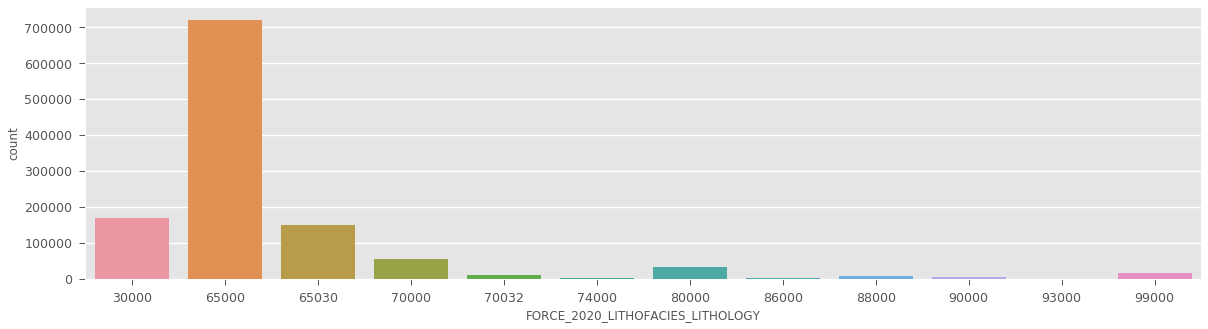

In [8]:
plt.figure(figsize=(20, 5))
sns.countplot(x="FORCE_2020_LITHOFACIES_LITHOLOGY", data=filled_df)

This is an unbalanced classes classification task. 

### DATA splitting

In [12]:
all_wells = filled_df.WELL.unique()

val_wells = ["16/10-1", "16/2-16"]
test_wells = ["16/11-1 ST3", "34/3-1 A"]
train_wells = [
    well_name for well_name in all_wells if well_name not in val_wells+test_wells]

### DATA preparation
Separate features from target (FORCE_2020_LITHOFACIES_LITHOLOGY) and remove FORCE_2020_LITHOFACIES_CONFIDENCE

In [13]:
train_mask = filled_df.WELL.isin(train_wells)
val_mask = filled_df.WELL.isin(val_wells)
test_mask = filled_df.WELL.isin(test_wells)

train_df = filled_df.loc[train_mask, :]
val_df = filled_df.loc[val_mask, :]
test_df = filled_df.loc[test_mask, :]

In [14]:
y_train = train_df.loc[:, "FORCE_2020_LITHOFACIES_LITHOLOGY"]
y_val = val_df.loc[:, "FORCE_2020_LITHOFACIES_LITHOLOGY"]
y_test = test_df.loc[:, "FORCE_2020_LITHOFACIES_LITHOLOGY"]

train_df.drop(columns="FORCE_2020_LITHOFACIES_LITHOLOGY", inplace=True)
val_df.drop(columns="FORCE_2020_LITHOFACIES_LITHOLOGY", inplace=True)
test_df.drop(columns="FORCE_2020_LITHOFACIES_LITHOLOGY", inplace=True)

/data/pau117/STAGIAIRES/YANKWA/conda/envs/leyanki_tf/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [15]:
X_train = train_df.drop(columns="FORCE_2020_LITHOFACIES_CONFIDENCE")
X_val = val_df.drop(columns="FORCE_2020_LITHOFACIES_CONFIDENCE")
X_test = test_df.drop(columns="FORCE_2020_LITHOFACIES_CONFIDENCE")

### Categorical features encoding

In [35]:
all_groups = sorted(list(X_train.GROUP.unique()))
all_formations = sorted(list(X_train.FORMATION.unique()))

def get_encoded_formation(x):
    try:
        return all_formations.index(x)
    except ValueError:
        return len(all_formations)
    
def get_encoded_group(x):
    try:
        return all_groups.index(x)
    except ValueError:
        return len(all_groups)

In [36]:
to_drop = ["GROUP","FORMATION","WELL"]
X_train["enc_FORMATION"] = X_train["FORMATION"].map(get_encoded_formation)
X_train["enc_GROUP"] = X_train["GROUP"].map(get_encoded_group)
X_train.drop(columns=to_drop,inplace=True)

X_val["enc_FORMATION"] = X_val["FORMATION"].map(get_encoded_formation)
X_val["enc_GROUP"] = X_val["GROUP"].map(get_encoded_group)
X_val.drop(columns=to_drop,inplace=True)

X_test["enc_FORMATION"] = X_test["FORMATION"].map(get_encoded_formation)
X_test["enc_GROUP"] = X_test["GROUP"].map(get_encoded_group)
X_test.drop(columns=to_drop,inplace=True)

## MODELISATION


In [43]:
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
from utils import plot_features_importance, penalty_score

### Baseline Model
We are going to use Catboost which is a tree-based model. The advantage of this model is that:
- it is very powerful for classification task (as a Gradient Boosting Method)
- It takes care of categorical features for us!
- It is fast to train (it uses GPU)
- It is explainable : As a tree model, we can look at features importance after training to get a feeling on features which are more useful during trees construction

In [79]:
catboost_classifier = CatBoostClassifier(iterations = 100, train_dir = data_folder)
catboost_classifier.fit(X_train, y_train,
                        eval_set=[(X_val, y_val)],
                        verbose=10)

Learning rate set to 0.299472
0:	learn: 1.2405823	test: 1.0584089	best: 1.0584089 (0)	total: 716ms	remaining: 1m 10s
10:	learn: 0.6347334	test: 0.5877728	best: 0.5613271 (9)	total: 7.42s	remaining: 1m
20:	learn: 0.5453117	test: 0.5421397	best: 0.5368245 (18)	total: 13.4s	remaining: 50.4s
30:	learn: 0.4995732	test: 0.5234625	best: 0.5234625 (30)	total: 19.6s	remaining: 43.5s
40:	learn: 0.4637073	test: 0.5276801	best: 0.5234625 (30)	total: 25.5s	remaining: 36.7s
50:	learn: 0.4422496	test: 0.5280556	best: 0.5234625 (30)	total: 31.4s	remaining: 30.2s
60:	learn: 0.4226590	test: 0.5315201	best: 0.5234625 (30)	total: 37.3s	remaining: 23.9s
70:	learn: 0.4074049	test: 0.5567446	best: 0.5234625 (30)	total: 43.1s	remaining: 17.6s
80:	learn: 0.3935288	test: 0.5545891	best: 0.5234625 (30)	total: 49.1s	remaining: 11.5s
90:	learn: 0.3824040	test: 0.5596056	best: 0.5234625 (30)	total: 55.1s	remaining: 5.45s
99:	learn: 0.3740410	test: 0.5703319	best: 0.5234625 (30)	total: 1m	remaining: 0us

bestTest = 

Train set; Penalty score and accuracy are :  -0.44805971720524296 0.8311840031555886

Val set; Penalty score and accuracy are :  -0.42883574007220215 0.8278339350180506

Test set; Penalty score and accuracy are :  -1.5983768689278026 0.5064867066146954

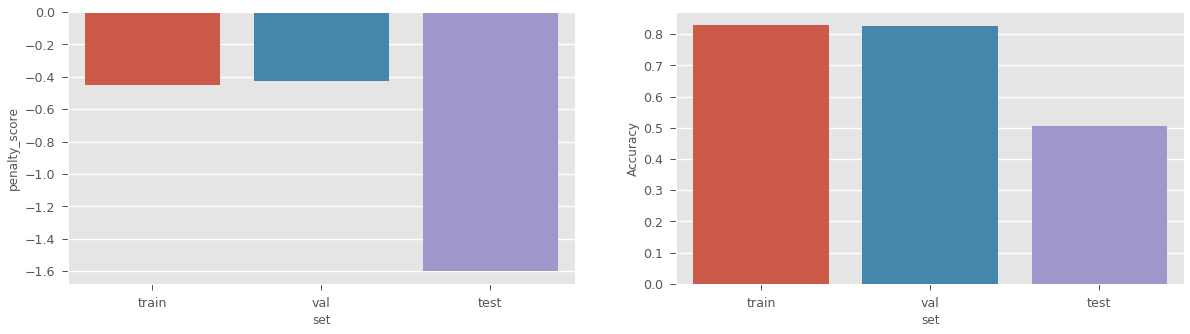

In [81]:
metrics = pd.DataFrame({"set":["train","val","test"],"penalty_score":[-0.448, -0.4288, -1.598],
                        "Accuracy":[0.83, 0.8278, 0.5064]})
fig, axes  = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x="set",y="penalty_score",data=metrics,ax=axes[0])
sns.barplot(x="set",y="Accuracy",data=metrics,ax=axes[1])

### classes weights
one way to deal with unbalanced classes is add weights to classes.

In [57]:
def get_class_weights(class_category):
    ### Compute classes weights according to classes frequency
    class_weights = compute_class_weight(
                'balanced', np.unique(class_category), class_category)
    class_weights = dict(enumerate(class_weights))
    
    #### change classes weights by adding more importance to some classes
    ucl = np.unique(class_category)
    class_weights_dict = {ucl[k]: np.log(v+1) for k, v in class_weights.items()}
    
    my_classes_importance = {ucl[k]: 1 for k in class_weights}
    my_classes_importance[65000] = 1.3
    my_classes_importance[80000] = 0.7
    my_classes_importance[74000] = 4
    my_classes_importance[70000] = 4
    my_classes_importance[70032] = 4
    my_classes_importance[65030] = 3
    my_classes_importance[86000] = 2
    
    class_weights_dict_f = {k: v*my_classes_importance[k] for k, v in class_weights_dict.items()}
    return class_weights_dict_f

In [59]:
class_category = filled_df.loc[:, "FORCE_2020_LITHOFACIES_LITHOLOGY"]
class_weights_dict = get_class_weights(class_category)

In [60]:
def run_grid_search(X_train, y_train, X_val, y_val, grid_params, data_folder, nb_iter=2):
    used_params = []
    all_results = []
    trained_models = []
    cat_1 = list(X_train.columns.values).index("enc_GROUP")
    cat_2 = list(X_train.columns.values).index("enc_FORMATION")

    initial_params = {"iterations": 1500, "learning_rate": 0.05, "depth": 4, "min_data_in_leaf": 2,
                      "bagging_temperature": 8, "border_count": 60, "grow_policy": 'Depthwise', "cat_features": [cat_1, cat_2],
                      "objective": 'MultiClassOneVsAll', "eval_metric": "TotalF1", "custom_metric": ['Accuracy', 'Precision', 'Recall'],
                      "early_stopping_rounds": 200, "task_type": 'GPU', "train_dir": data_folder}

    for iteration in range(nb_iter):
        catboost_classifier = CatBoostClassifier(**initial_params)
        find_unseen_params = True
        while find_unseen_params:
            clf_params = {}
            my_p = []
            for key in grid_params:
                clf_params[key] = np.random.choice(grid_params[key])
                my_p.append(clf_params[key])
            if my_p not in used_params:
                used_params.append(my_p)
                find_unseen_params = False
                print("New set of prams to test for iteration {}: {}..".format(
                    iteration, clf_params))
            else:
                print("{} already tested!".format(clf_params))
                clf_params = {}

        # we found a set of params
        catboost_classifier.set_params(**clf_params)

        catboost_classifier.fit(X_train, y_train,
                                eval_set=[(X_val, y_val)],
                                verbose=10)
        all_results.append(catboost_classifier.get_evals_result())
        trained_models.append(catboost_classifier)
    return used_params, all_results, trained_models

In [61]:
grid_params = {"learning_rate": [0.03, 0.05, 0.08, 0.1],
               "depth": [4, 6, 8],
               "min_data_in_leaf": [2, 50, 200],
               "bagging_temperature": [4, 8],
               "border_count": [30, 60, 100]}


used_params, all_results, trained_models = run_grid_search(X_train, y_train, X_test, y_test,
                                                           grid_params, data_folder, nb_iter=50)

New set of prams to test for iteration 0: {'learning_rate': 0.08, 'depth': 4, 'min_data_in_leaf': 50, 'bagging_temperature': 4, 'border_count': 100}..
0:	learn: 0.6685843	test: 0.7134692	best: 0.7134692 (0)	total: 41.7ms	remaining: 1m 2s
10:	learn: 0.6930573	test: 0.6659121	best: 0.7261262 (2)	total: 395ms	remaining: 53.5s
20:	learn: 0.7008080	test: 0.6682157	best: 0.7261262 (2)	total: 742ms	remaining: 52.3s
30:	learn: 0.7213843	test: 0.6935578	best: 0.7261262 (2)	total: 1.09s	remaining: 51.5s
40:	learn: 0.7371951	test: 0.7319319	best: 0.7497259 (34)	total: 1.43s	remaining: 50.9s
50:	learn: 0.7515641	test: 0.5905905	best: 0.7894806 (48)	total: 1.77s	remaining: 50.4s
60:	learn: 0.7633139	test: 0.6075716	best: 0.7894806 (48)	total: 2.12s	remaining: 50s
70:	learn: 0.7716725	test: 0.6217595	best: 0.7894806 (48)	total: 2.46s	remaining: 49.4s
80:	learn: 0.7801636	test: 0.6210831	best: 0.7894806 (48)	total: 2.79s	remaining: 48.9s
90:	learn: 0.7861033	test: 0.6230011	best: 0.7894806 (48)	total

160:	learn: 0.8725285	test: 0.5854368	best: 0.6092501 (3)	total: 7.17s	remaining: 59.6s
170:	learn: 0.8740362	test: 0.5819392	best: 0.6092501 (3)	total: 7.59s	remaining: 59s
180:	learn: 0.8753020	test: 0.5818855	best: 0.6092501 (3)	total: 8.02s	remaining: 58.5s
190:	learn: 0.8766771	test: 0.5846729	best: 0.6092501 (3)	total: 8.46s	remaining: 58s
200:	learn: 0.8775878	test: 0.5846716	best: 0.6092501 (3)	total: 8.9s	remaining: 57.5s
bestTest = 0.6092501442
bestIteration = 3
Shrink model to first 4 iterations.
New set of prams to test for iteration 4: {'learning_rate': 0.08, 'depth': 8, 'min_data_in_leaf': 2, 'bagging_temperature': 8, 'border_count': 100}..
0:	learn: 0.7343866	test: 0.4216544	best: 0.4216544 (0)	total: 51.7ms	remaining: 1m 17s
10:	learn: 0.7704427	test: 0.5154892	best: 0.7220460 (3)	total: 526ms	remaining: 1m 11s
20:	learn: 0.7799277	test: 0.5222423	best: 0.7220460 (3)	total: 995ms	remaining: 1m 10s
30:	learn: 0.7902752	test: 0.5287572	best: 0.7220460 (3)	total: 1.46s	rem

170:	learn: 0.8718674	test: 0.5784688	best: 0.7098932 (8)	total: 7.47s	remaining: 58.1s
180:	learn: 0.8733943	test: 0.5805481	best: 0.7098932 (8)	total: 7.9s	remaining: 57.5s
190:	learn: 0.8743687	test: 0.5775732	best: 0.7098932 (8)	total: 8.31s	remaining: 57s
200:	learn: 0.8759367	test: 0.5771707	best: 0.7098932 (8)	total: 8.74s	remaining: 56.5s
bestTest = 0.7098932061
bestIteration = 8
Shrink model to first 9 iterations.
New set of prams to test for iteration 7: {'learning_rate': 0.05, 'depth': 6, 'min_data_in_leaf': 200, 'bagging_temperature': 8, 'border_count': 60}..
0:	learn: 0.6852108	test: 0.4231696	best: 0.4231696 (0)	total: 42.6ms	remaining: 1m 3s
10:	learn: 0.6959546	test: 0.4892980	best: 0.7225081 (2)	total: 422ms	remaining: 57.1s
20:	learn: 0.7048853	test: 0.4804249	best: 0.7225081 (2)	total: 794ms	remaining: 55.9s
30:	learn: 0.7237998	test: 0.4793543	best: 0.7225081 (2)	total: 1.17s	remaining: 55.2s
40:	learn: 0.7335725	test: 0.4757597	best: 0.7225081 (2)	total: 1.53s	rema

170:	learn: 0.8154733	test: 0.6311886	best: 0.7205227 (4)	total: 5.69s	remaining: 44.2s
180:	learn: 0.8178150	test: 0.6345074	best: 0.7205227 (4)	total: 6.01s	remaining: 43.8s
190:	learn: 0.8194478	test: 0.6336460	best: 0.7205227 (4)	total: 6.33s	remaining: 43.4s
200:	learn: 0.8209668	test: 0.6314116	best: 0.7205227 (4)	total: 6.66s	remaining: 43s
bestTest = 0.7205226753
bestIteration = 4
Shrink model to first 5 iterations.
New set of prams to test for iteration 11: {'learning_rate': 0.03, 'depth': 8, 'min_data_in_leaf': 200, 'bagging_temperature': 4, 'border_count': 30}..
0:	learn: 0.7614198	test: 0.5700712	best: 0.5700712 (0)	total: 52.6ms	remaining: 1m 18s
10:	learn: 0.7925219	test: 0.5708790	best: 0.5997240 (5)	total: 518ms	remaining: 1m 10s
20:	learn: 0.8016921	test: 0.5668021	best: 0.5997240 (5)	total: 983ms	remaining: 1m 9s
30:	learn: 0.8119879	test: 0.5581250	best: 0.5997240 (5)	total: 1.45s	remaining: 1m 8s
40:	learn: 0.8182580	test: 0.5644640	best: 0.5997240 (5)	total: 1.92s	

170:	learn: 0.8260953	test: 0.6227152	best: 0.6227152 (170)	total: 6.53s	remaining: 50.7s
180:	learn: 0.8285654	test: 0.6266519	best: 0.6266519 (180)	total: 6.9s	remaining: 50.3s
190:	learn: 0.8312584	test: 0.6304251	best: 0.6304251 (190)	total: 7.27s	remaining: 49.9s
200:	learn: 0.8333344	test: 0.6330574	best: 0.6332711 (197)	total: 7.64s	remaining: 49.4s
210:	learn: 0.8351078	test: 0.6358712	best: 0.6362717 (207)	total: 8.01s	remaining: 48.9s
220:	learn: 0.8370323	test: 0.6382076	best: 0.6382076 (220)	total: 8.38s	remaining: 48.5s
230:	learn: 0.8390979	test: 0.6398082	best: 0.6398082 (230)	total: 8.75s	remaining: 48.1s
240:	learn: 0.8405830	test: 0.6402993	best: 0.6405659 (232)	total: 9.12s	remaining: 47.6s
250:	learn: 0.8418533	test: 0.6421251	best: 0.6421251 (250)	total: 9.48s	remaining: 47.2s
260:	learn: 0.8428082	test: 0.6432725	best: 0.6432725 (260)	total: 9.86s	remaining: 46.8s
270:	learn: 0.8438539	test: 0.6439637	best: 0.6442224 (268)	total: 10.2s	remaining: 46.3s
280:	learn:

250:	learn: 0.8552261	test: 0.6555233	best: 0.6570978 (221)	total: 9.62s	remaining: 47.9s
260:	learn: 0.8561672	test: 0.6549244	best: 0.6570978 (221)	total: 9.99s	remaining: 47.4s
270:	learn: 0.8570364	test: 0.6551306	best: 0.6570978 (221)	total: 10.4s	remaining: 47s
280:	learn: 0.8579808	test: 0.6548760	best: 0.6570978 (221)	total: 10.7s	remaining: 46.5s
290:	learn: 0.8591470	test: 0.6541723	best: 0.6570978 (221)	total: 11.1s	remaining: 46.1s
300:	learn: 0.8598224	test: 0.6543895	best: 0.6570978 (221)	total: 11.5s	remaining: 45.6s
310:	learn: 0.8606725	test: 0.6521298	best: 0.6570978 (221)	total: 11.8s	remaining: 45.2s
320:	learn: 0.8615923	test: 0.6520159	best: 0.6570978 (221)	total: 12.2s	remaining: 44.8s
330:	learn: 0.8624318	test: 0.6516044	best: 0.6570978 (221)	total: 12.6s	remaining: 44.4s
340:	learn: 0.8632588	test: 0.6515880	best: 0.6570978 (221)	total: 12.9s	remaining: 44s
350:	learn: 0.8639031	test: 0.6517792	best: 0.6570978 (221)	total: 13.3s	remaining: 43.6s
360:	learn: 0.

150:	learn: 0.7725113	test: 0.5066265	best: 0.7223369 (2)	total: 5.76s	remaining: 51.4s
160:	learn: 0.7764959	test: 0.5071107	best: 0.7223369 (2)	total: 6.14s	remaining: 51.1s
170:	learn: 0.7792605	test: 0.5093817	best: 0.7223369 (2)	total: 6.51s	remaining: 50.6s
180:	learn: 0.7824053	test: 0.5101094	best: 0.7223369 (2)	total: 6.88s	remaining: 50.1s
190:	learn: 0.7853432	test: 0.5096358	best: 0.7223369 (2)	total: 7.24s	remaining: 49.6s
200:	learn: 0.7877203	test: 0.5108393	best: 0.7223369 (2)	total: 7.6s	remaining: 49.1s
bestTest = 0.7223368745
bestIteration = 2
Shrink model to first 3 iterations.
{'learning_rate': 0.03, 'depth': 8, 'min_data_in_leaf': 200, 'bagging_temperature': 4, 'border_count': 30} already tested!
New set of prams to test for iteration 20: {'learning_rate': 0.1, 'depth': 8, 'min_data_in_leaf': 2, 'bagging_temperature': 8, 'border_count': 100}..
0:	learn: 0.7343866	test: 0.4216544	best: 0.4216544 (0)	total: 52.2ms	remaining: 1m 18s
10:	learn: 0.7682581	test: 0.51584

220:	learn: 0.8630750	test: 0.6434422	best: 0.6488466 (132)	total: 8.27s	remaining: 47.9s
230:	learn: 0.8643260	test: 0.6451818	best: 0.6488466 (132)	total: 8.64s	remaining: 47.5s
240:	learn: 0.8655620	test: 0.6438729	best: 0.6488466 (132)	total: 9s	remaining: 47s
250:	learn: 0.8665104	test: 0.6421372	best: 0.6488466 (132)	total: 9.36s	remaining: 46.6s
260:	learn: 0.8676196	test: 0.6412018	best: 0.6488466 (132)	total: 9.74s	remaining: 46.3s
270:	learn: 0.8683852	test: 0.6406831	best: 0.6488466 (132)	total: 10.1s	remaining: 45.9s
280:	learn: 0.8693227	test: 0.6403942	best: 0.6488466 (132)	total: 10.5s	remaining: 45.5s
290:	learn: 0.8703279	test: 0.6379976	best: 0.6488466 (132)	total: 10.8s	remaining: 45s
300:	learn: 0.8709872	test: 0.6384721	best: 0.6488466 (132)	total: 11.2s	remaining: 44.6s
310:	learn: 0.8719826	test: 0.6399134	best: 0.6488466 (132)	total: 11.6s	remaining: 44.2s
320:	learn: 0.8729064	test: 0.6378387	best: 0.6488466 (132)	total: 11.9s	remaining: 43.8s
330:	learn: 0.873

0:	learn: 0.7343866	test: 0.4216544	best: 0.4216544 (0)	total: 50.4ms	remaining: 1m 15s
10:	learn: 0.7572272	test: 0.5173930	best: 0.5385205 (3)	total: 541ms	remaining: 1m 13s
20:	learn: 0.7613567	test: 0.5080004	best: 0.5385205 (3)	total: 1.03s	remaining: 1m 12s
30:	learn: 0.7670048	test: 0.5059551	best: 0.5385205 (3)	total: 1.51s	remaining: 1m 11s
40:	learn: 0.7730199	test: 0.5170220	best: 0.5385205 (3)	total: 1.99s	remaining: 1m 10s
50:	learn: 0.7804758	test: 0.5101510	best: 0.5385205 (3)	total: 2.47s	remaining: 1m 10s
60:	learn: 0.7855062	test: 0.5152442	best: 0.5385205 (3)	total: 2.95s	remaining: 1m 9s
70:	learn: 0.7897107	test: 0.5189669	best: 0.5385205 (3)	total: 3.42s	remaining: 1m 8s
80:	learn: 0.7919898	test: 0.5150084	best: 0.5385205 (3)	total: 3.88s	remaining: 1m 7s
90:	learn: 0.7938696	test: 0.5155110	best: 0.5385205 (3)	total: 4.33s	remaining: 1m 7s
100:	learn: 0.7969856	test: 0.5153540	best: 0.5385205 (3)	total: 4.77s	remaining: 1m 6s
110:	learn: 0.8010288	test: 0.518285

180:	learn: 0.8658103	test: 0.6499996	best: 0.6507808 (159)	total: 6.89s	remaining: 50.2s
190:	learn: 0.8667922	test: 0.6485397	best: 0.6507808 (159)	total: 7.26s	remaining: 49.8s
200:	learn: 0.8678547	test: 0.6488995	best: 0.6507808 (159)	total: 7.63s	remaining: 49.3s
210:	learn: 0.8687409	test: 0.6500428	best: 0.6507808 (159)	total: 8s	remaining: 48.9s
220:	learn: 0.8694379	test: 0.6482313	best: 0.6507808 (159)	total: 8.37s	remaining: 48.4s
230:	learn: 0.8707319	test: 0.6474954	best: 0.6507808 (159)	total: 8.74s	remaining: 48s
240:	learn: 0.8714947	test: 0.6466209	best: 0.6507808 (159)	total: 9.11s	remaining: 47.6s
250:	learn: 0.8722376	test: 0.6462239	best: 0.6507808 (159)	total: 9.48s	remaining: 47.2s
260:	learn: 0.8731844	test: 0.6446503	best: 0.6507808 (159)	total: 9.85s	remaining: 46.7s
270:	learn: 0.8739916	test: 0.6467535	best: 0.6507808 (159)	total: 10.2s	remaining: 46.3s
280:	learn: 0.8747980	test: 0.6461936	best: 0.6507808 (159)	total: 10.6s	remaining: 45.9s
290:	learn: 0.8

40:	learn: 0.8032093	test: 0.6162957	best: 0.6187915 (37)	total: 1.57s	remaining: 55.9s
50:	learn: 0.8149247	test: 0.6328475	best: 0.6328475 (50)	total: 1.95s	remaining: 55.4s
60:	learn: 0.8233795	test: 0.6388275	best: 0.6388275 (60)	total: 2.32s	remaining: 54.8s
70:	learn: 0.8295408	test: 0.6400028	best: 0.6410134 (65)	total: 2.69s	remaining: 54.2s
80:	learn: 0.8353836	test: 0.6429348	best: 0.6429348 (80)	total: 3.06s	remaining: 53.7s
90:	learn: 0.8396457	test: 0.6449220	best: 0.6453234 (89)	total: 3.43s	remaining: 53.1s
100:	learn: 0.8423535	test: 0.6459548	best: 0.6462573 (99)	total: 3.8s	remaining: 52.6s
110:	learn: 0.8454835	test: 0.6460384	best: 0.6466743 (106)	total: 4.17s	remaining: 52.2s
120:	learn: 0.8482739	test: 0.6463441	best: 0.6466743 (106)	total: 4.54s	remaining: 51.7s
130:	learn: 0.8509657	test: 0.6465142	best: 0.6471082 (124)	total: 4.91s	remaining: 51.3s
140:	learn: 0.8527471	test: 0.6460728	best: 0.6473660 (132)	total: 5.27s	remaining: 50.8s
150:	learn: 0.8547588	te

370:	learn: 0.8697495	test: 0.5656514	best: 0.5672202 (346)	total: 16.7s	remaining: 50.9s
380:	learn: 0.8704614	test: 0.5645986	best: 0.5672202 (346)	total: 17.2s	remaining: 50.4s
390:	learn: 0.8714664	test: 0.5649818	best: 0.5672202 (346)	total: 17.6s	remaining: 50s
400:	learn: 0.8721880	test: 0.5654686	best: 0.5672202 (346)	total: 18.1s	remaining: 49.5s
410:	learn: 0.8726587	test: 0.5650176	best: 0.5672202 (346)	total: 18.5s	remaining: 49s
420:	learn: 0.8733954	test: 0.5652764	best: 0.5672202 (346)	total: 18.9s	remaining: 48.6s
430:	learn: 0.8741486	test: 0.5651599	best: 0.5672202 (346)	total: 19.4s	remaining: 48.1s
440:	learn: 0.8747096	test: 0.5653553	best: 0.5672202 (346)	total: 19.8s	remaining: 47.6s
450:	learn: 0.8751625	test: 0.5655063	best: 0.5672202 (346)	total: 20.3s	remaining: 47.2s
460:	learn: 0.8757193	test: 0.5652045	best: 0.5672202 (346)	total: 20.7s	remaining: 46.7s
470:	learn: 0.8762634	test: 0.5655646	best: 0.5672202 (346)	total: 21.2s	remaining: 46.2s
480:	learn: 0.

240:	learn: 0.8279690	test: 0.6568196	best: 0.7894806 (48)	total: 8.06s	remaining: 42.1s
bestTest = 0.7894805695
bestIteration = 48
Shrink model to first 49 iterations.
New set of prams to test for iteration 38: {'learning_rate': 0.1, 'depth': 6, 'min_data_in_leaf': 200, 'bagging_temperature': 8, 'border_count': 100}..
0:	learn: 0.6798892	test: 0.4097025	best: 0.4097025 (0)	total: 42.2ms	remaining: 1m 3s
10:	learn: 0.7119897	test: 0.5132340	best: 0.7467527 (8)	total: 429ms	remaining: 58.1s
20:	learn: 0.7256743	test: 0.5291319	best: 0.7467527 (8)	total: 808ms	remaining: 56.9s
30:	learn: 0.7470173	test: 0.5149440	best: 0.7467527 (8)	total: 1.18s	remaining: 56s
40:	learn: 0.7662474	test: 0.4974411	best: 0.7467527 (8)	total: 1.56s	remaining: 55.6s
50:	learn: 0.7774682	test: 0.5010643	best: 0.7467527 (8)	total: 1.93s	remaining: 55s
60:	learn: 0.7878708	test: 0.5178536	best: 0.7467527 (8)	total: 2.31s	remaining: 54.5s
70:	learn: 0.7977541	test: 0.5426449	best: 0.7467527 (8)	total: 2.69s	rema

270:	learn: 0.8582263	test: 0.6484643	best: 0.6494517 (263)	total: 10.2s	remaining: 46.1s
280:	learn: 0.8592015	test: 0.6481888	best: 0.6494517 (263)	total: 10.5s	remaining: 45.7s
290:	learn: 0.8601437	test: 0.6472169	best: 0.6494517 (263)	total: 10.9s	remaining: 45.3s
300:	learn: 0.8610436	test: 0.6482587	best: 0.6494517 (263)	total: 11.3s	remaining: 44.9s
310:	learn: 0.8619086	test: 0.6488803	best: 0.6494517 (263)	total: 11.6s	remaining: 44.5s
320:	learn: 0.8628211	test: 0.6486286	best: 0.6494517 (263)	total: 12s	remaining: 44s
330:	learn: 0.8635321	test: 0.6472397	best: 0.6494517 (263)	total: 12.4s	remaining: 43.6s
340:	learn: 0.8643605	test: 0.6458928	best: 0.6494517 (263)	total: 12.7s	remaining: 43.2s
350:	learn: 0.8651191	test: 0.6462573	best: 0.6494517 (263)	total: 13.1s	remaining: 42.8s
360:	learn: 0.8656201	test: 0.6447999	best: 0.6494517 (263)	total: 13.4s	remaining: 42.4s
370:	learn: 0.8661753	test: 0.6462783	best: 0.6494517 (263)	total: 13.8s	remaining: 42s
380:	learn: 0.86

200:	learn: 0.7887279	test: 0.5392368	best: 0.6401736 (2)	total: 6.57s	remaining: 42.5s
bestTest = 0.6401735959
bestIteration = 2
Shrink model to first 3 iterations.
New set of prams to test for iteration 44: {'learning_rate': 0.05, 'depth': 6, 'min_data_in_leaf': 50, 'bagging_temperature': 4, 'border_count': 60}..
0:	learn: 0.7132061	test: 0.4929841	best: 0.4929841 (0)	total: 45.2ms	remaining: 1m 7s
10:	learn: 0.7393188	test: 0.5750496	best: 0.5858708 (9)	total: 432ms	remaining: 58.5s
20:	learn: 0.7522079	test: 0.5766115	best: 0.5858708 (9)	total: 813ms	remaining: 57.2s
30:	learn: 0.7673521	test: 0.5877043	best: 0.5877043 (30)	total: 1.2s	remaining: 56.7s
40:	learn: 0.7791229	test: 0.6118604	best: 0.6118604 (40)	total: 1.58s	remaining: 56.2s
50:	learn: 0.7888168	test: 0.6067643	best: 0.6163084 (48)	total: 1.97s	remaining: 56s
60:	learn: 0.7961124	test: 0.6080566	best: 0.6171776 (51)	total: 2.35s	remaining: 55.5s
70:	learn: 0.8055274	test: 0.6034553	best: 0.6171776 (51)	total: 2.73s	re

220:	learn: 0.8372167	test: 0.6419054	best: 0.6419867 (219)	total: 8.36s	remaining: 48.4s
230:	learn: 0.8389997	test: 0.6435222	best: 0.6443116 (223)	total: 8.73s	remaining: 48s
240:	learn: 0.8404767	test: 0.6437511	best: 0.6443116 (223)	total: 9.1s	remaining: 47.5s
250:	learn: 0.8417275	test: 0.6456073	best: 0.6456787 (249)	total: 9.47s	remaining: 47.1s
260:	learn: 0.8428083	test: 0.6457495	best: 0.6458225 (258)	total: 9.84s	remaining: 46.7s
270:	learn: 0.8438232	test: 0.6453392	best: 0.6458684 (265)	total: 10.2s	remaining: 46.3s
280:	learn: 0.8451455	test: 0.6454398	best: 0.6458684 (265)	total: 10.6s	remaining: 45.9s
290:	learn: 0.8462700	test: 0.6459298	best: 0.6459340 (288)	total: 11s	remaining: 45.5s
300:	learn: 0.8472363	test: 0.6465188	best: 0.6465188 (299)	total: 11.3s	remaining: 45.1s
310:	learn: 0.8485335	test: 0.6461915	best: 0.6466916 (304)	total: 11.7s	remaining: 44.8s
320:	learn: 0.8494094	test: 0.6472204	best: 0.6472204 (320)	total: 12.1s	remaining: 44.4s
330:	learn: 0.8

80:	learn: 0.7486491	test: 0.5137943	best: 0.6651346 (1)	total: 2.67s	remaining: 46.8s
90:	learn: 0.7574928	test: 0.5254415	best: 0.6651346 (1)	total: 3s	remaining: 46.4s
100:	learn: 0.7648388	test: 0.5266884	best: 0.6651346 (1)	total: 3.32s	remaining: 46s
110:	learn: 0.7722209	test: 0.5326254	best: 0.6651346 (1)	total: 3.65s	remaining: 45.7s
120:	learn: 0.7793562	test: 0.5434461	best: 0.6651346 (1)	total: 3.97s	remaining: 45.3s
130:	learn: 0.7840565	test: 0.5358097	best: 0.6651346 (1)	total: 4.3s	remaining: 44.9s
140:	learn: 0.7881692	test: 0.5445570	best: 0.6651346 (1)	total: 4.62s	remaining: 44.5s
150:	learn: 0.7916659	test: 0.5501746	best: 0.6651346 (1)	total: 4.95s	remaining: 44.2s
160:	learn: 0.7937546	test: 0.5616302	best: 0.6651346 (1)	total: 5.28s	remaining: 43.9s
170:	learn: 0.7967698	test: 0.5706374	best: 0.6651346 (1)	total: 5.61s	remaining: 43.6s
180:	learn: 0.7994832	test: 0.5732834	best: 0.6651346 (1)	total: 5.94s	remaining: 43.3s
190:	learn: 0.8017341	test: 0.5752204	be

In [62]:
accuracy = []
f1 = []

recall = []
precision = []
model_ind = []
for i in range(len(all_results)):
    model_ind.append(i)
    accuracy.append(np.max(all_results[i]["validation"]["Accuracy"]))
    f1.append(np.max(all_results[i]["validation"]["TotalF1"]))
res_df = pd.DataFrame({"model": model_ind, "accuracy": accuracy, "f1": f1})

In [63]:
res_df.sort_values(by="f1", ascending=False).head()

,model,accuracy,f1
0,0,0.777067,0.789481
37,37,0.777067,0.789481
28,28,0.767700,0.765969
38,38,0.744197,0.746753
20,20,0.737681,0.736342


In [82]:
catboost_classifier = trained_models[0]

## Evaluation

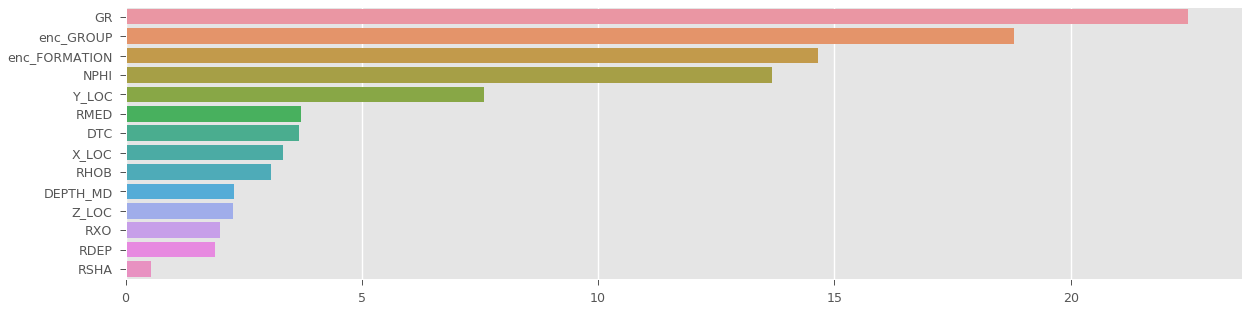

In [83]:
plot_features_importance(catboost_classifier.feature_importances_, X_val.columns, figsize=(20, 5))

In [86]:
y_val_pred = catboost_classifier.predict(X_val)
y_test_pred = catboost_classifier.predict(X_test)
y_train_pred = catboost_classifier.predict(X_train)

pst = penalty_score(y_train.values, y_train_pred.flatten().astype(int),penalty_matrix=penalty)
act = accuracy_score(y_train.values, y_train_pred)
print("Train set; Penalty score and accuracy are : ",pst,act)
psv = penalty_score(y_val.values, y_val_pred.flatten().astype(int),penalty_matrix=penalty)
acv = accuracy_score(y_val.values, y_val_pred)
print("Val set; Penalty score and accuracy are : ",psv,acv)
pste = penalty_score(y_test.values, y_test_pred.flatten().astype(int),penalty_matrix=penalty)
acte = accuracy_score(y_test.values, y_test_pred)
print("Test set; Penalty score and accuracy are : ",pste,acte)

Train set; Penalty score and accuracy are :  -0.5760105301779817 0.7844063104665687
Val set; Penalty score and accuracy are :  -0.5026037906137184 0.7988808664259928
Test set; Penalty score and accuracy are :  -0.5036578625865379 0.777066728721857


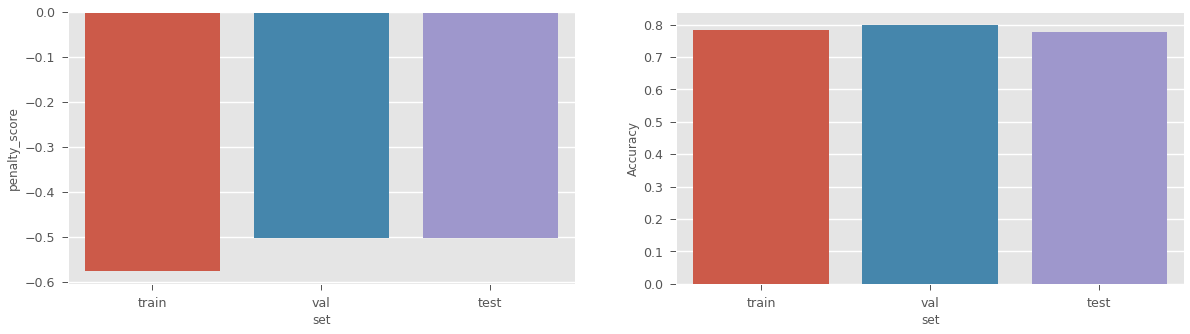

In [87]:
metrics = pd.DataFrame({"set":["train","val","test"],"penalty_score":[pst, psv, pste],
                        "Accuracy":[act, acv, acte]})
fig, axes  = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x="set",y="penalty_score",data=metrics,ax=axes[0])
sns.barplot(x="set",y="Accuracy",data=metrics,ax=axes[1])

Text(0.5, 1.0, 'confusion matrix')

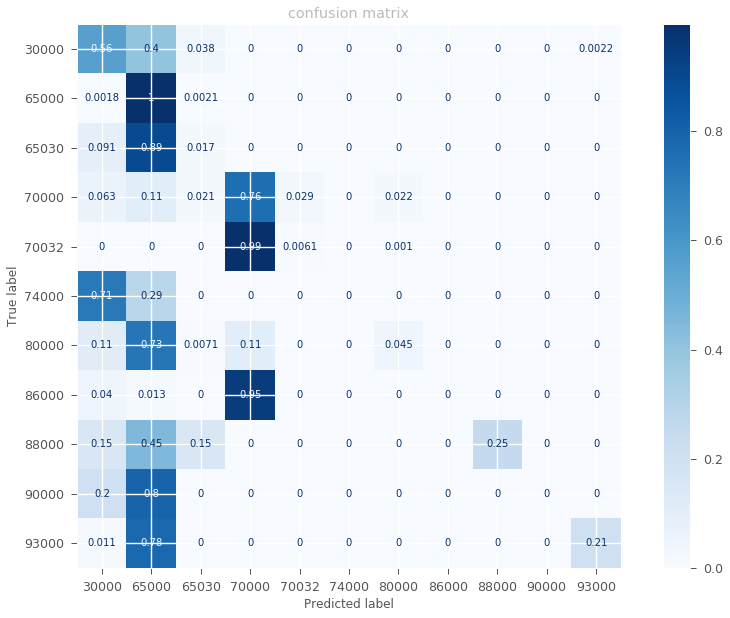

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
disp = plot_confusion_matrix(catboost_classifier, X_val, y_val,
                             cmap=plt.cm.Blues,
                             normalize="true", ax=ax)
disp.ax_.set_title("confusion matrix")

## Saving trained model

In [72]:
from joblib import dump, load

In [73]:
# model
model_name = 'catboost_final'
catboost_classifier.save_model(data_folder + model_name)